In [2]:
import os

In [3]:
import numpy as np
import pandas as pd


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


In [22]:
device = torch.device(
'cuda:0' if torch.cuda.is_available() else 'cpu' 
)
device

device(type='cpu')

In [49]:
batch_size = 256
num_workers = 1
lr = 1e-4
epochs = 3

In [50]:
from torchvision import transforms
image_size = 28
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [60]:
data_transform = transforms.Compose([
 #   transforms.ToPILImage(),   # 这一步取决于后续的数据读取方式，如果使用内置数据集则不需要
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [61]:
## 读取方式一：使用torchvision自带数据集，下载可能需要一段时间
from torchvision import datasets
root_dir = '/home/yunwanx/git/ds/fashionMNIST'
train_data = datasets.FashionMNIST(
    root = root_dir,
    train = True,
    download = True,
    transform = data_transform
)
test_data = datasets.FashionMNIST(
    root=root_dir, 
    train=False, 
    download=True, 
    transform=data_transform
)

In [74]:
train_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /home/yunwanx/git/ds/fashionMNIST
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=28, interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )

In [62]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

torch.Size([256, 1, 28, 28]) torch.Size([256])


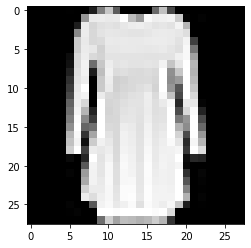

In [63]:
import matplotlib.pyplot as plt
image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[0][0], cmap="gray")

In [64]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

model = Net()
#model = model.cuda() #gpu
# model = nn.DataParallel(model).cuda() # 多卡

In [65]:
criterion = nn.CrossEntropyLoss()

In [66]:
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [70]:
def train(epoch):
    model.train()
    train_loss = 0
    for data, label in train_loader:
        #data, label = data.cuda(), label.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
    train_loss = train_loss/len(train_loader.dataset)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

In [71]:
def val(epoch):       
    model.eval()
    val_loss = 0
    gt_labels = []
    pred_labels = []
    with torch.no_grad():
        for data, label in test_loader:
           # data, label = data.cuda(), label.cuda()
            output = model(data)
            preds = torch.argmax(output, 1)
            gt_labels.append(label.cpu().data.numpy())
            pred_labels.append(preds.cpu().data.numpy())
            loss = criterion(output, label)
            val_loss += loss.item()*data.size(0)
    val_loss = val_loss/len(test_loader.dataset)
    gt_labels, pred_labels = np.concatenate(gt_labels), np.concatenate(pred_labels)
    acc = np.sum(gt_labels==pred_labels)/len(pred_labels)
    print('Epoch: {} \tValidation Loss: {:.6f}, Accuracy: {:6f}'.format(epoch, val_loss, acc))

In [72]:
for epoch in range(1, epochs+1):
    train(epoch)
    val(epoch)

Epoch: 1 	Training Loss: 0.658910
Epoch: 1 	Validation Loss: 0.480774, Accuracy: 0.824100
Epoch: 2 	Training Loss: 0.421687
Epoch: 2 	Validation Loss: 0.369700, Accuracy: 0.868200
Epoch: 3 	Training Loss: 0.364189
Epoch: 3 	Validation Loss: 0.325282, Accuracy: 0.883800


In [73]:
save_path = "./FahionModel.pkl"
torch.save(model, save_path)